# Low Visibility Road Conditions Simulations
This notebook demonstrates how to use Python to simulate the following conditions <br>
* Rain Simulation
* Fog Simulation
* Extreme Dark Simulation
* Extreme Bright Simulation

These simulation functions are used for image preprocessing in the experimental process.

In [1]:
import pandas as pd
from PIL import Image, ImageEnhance, ImageFilter 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import random
import cv2

In [2]:
img1 = np.array(Image.open('sample.png'))
img2 = np.array(Image.open('sample3.png'))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGRA2BGR)
img3 = np.array(Image.open('sample4.png'))
img3 = cv2.cvtColor(img3, cv2.COLOR_BGRA2BGR)

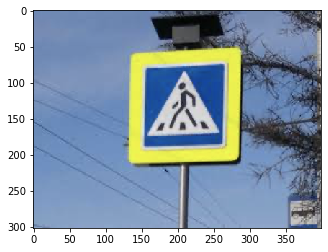

In [3]:
plt.imshow(img2)

### Rain

In [4]:
def generate_random_lines(imshape,slant,drop_length,n_drops):    
    drops=[]    
    for i in range(n_drops): ## If You want heavy rain, try increasing this        
        if slant<0:            
            x= np.random.randint(slant,imshape[1])        
        else:            
            x= np.random.randint(0,imshape[1]-slant)        
            y= np.random.randint(0,imshape[0]-drop_length)        
            drops.append((x,y))    
    return drops            
    
def add_rain(image, drop_length, drop_width, n_drops):  
    # copy image to prevent original image overwrite
    new_img = image.copy()
    
    # rain drops setting
    slant_extreme = 8
    slant= np.random.randint(1,slant_extreme)  
    drop_color=(220,220,220) ## a shade of light gray    
    imshape = new_img.shape 
    rain_drops= generate_random_lines(imshape,slant,drop_length, n_drops)
    
    # add rain drops to image 
    for rain_drop in rain_drops: 
        new_img = cv2.line(new_img,(rain_drop[0],rain_drop[1]),(rain_drop[0]+slant,rain_drop[1]+drop_length),drop_color,drop_width)
    new_img = cv2.blur(new_img,(2,1)) # blur image 
    new_img = np.floor(new_img*0.6) # bring down image brightness 
    new_img = new_img.astype(int) # convert image back into int format
    return new_img

In [9]:
type(img1)

numpy.ndarray

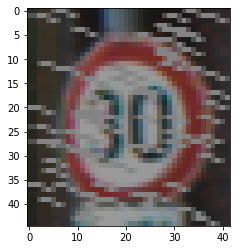

In [5]:
new_img = add_rain(image = img1, drop_length = 1, drop_width = 1, n_drops = 80)
plt.imshow(new_img)

plt.imsave('sample1_rain.jpeg', new_img.astype(np.uint8))

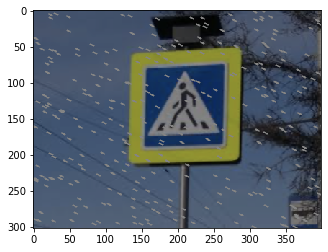

In [6]:
new_img = add_rain(image = img2, drop_length = 2, drop_width = 2, n_drops = 300)
plt.imshow(new_img)

plt.imsave('sample3_rain.jpeg', new_img.astype(np.uint8))

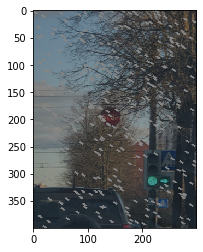

In [83]:
new_img = add_rain(image = img3, drop_length = 3, drop_width = 2, n_drops = 300)
plt.imshow(new_img)

plt.imsave('sample4_rain.jpeg', new_img.astype(np.uint8))

### Foggy

In [263]:
def gen_patches(imshape, num):
    h, w = np.ceil(np.array(imshape[:2])*0.15).astype(int)
    index = 0
    shapes = []
    while index < num:
        y = np.random.choice(list(range(imshape[0]))) # how many rows of pixels
        x = np.random.choice(list(range(imshape[1]))) # how many columns of pixels
        if x + h < (imshape[1]) and y + w < imshape[0]:
            index += 1
            shape = (y, y + h, x, x + w)
            shapes.append(shape)
    return shapes

def get_black_pixels(image):
    imagePIL = Image.fromarray(np.uint8(image)).convert('RGB')
    pixels = imagePIL.getdata()
    nblack = 0
    for pixel in pixels:
        if sum(pixel) == 0:
            nblack += 1
    percent_black = nblack/len(pixels)
    return percent_black

def reduce_black_pixels(img):
    image = img.copy()
    threshold_level = 50
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    coords = np.column_stack(np.where(gray < threshold_level)) # find coords of pixels that are black
    indexLst = random.sample(list(range(len(coords))), int(len(coords)*0.2))
    for index in indexLst:
        loc = coords[index]
        image[loc[0], loc[1],:] += random.randint(100, 180)
    return image

def add_fog(img, patches = 50):
    image = img.copy()
    # step 0: check for black pixel components
    percent = get_black_pixels(image)
    if percent >= 0.25:
        image = reduce_black_pixels(image)
        
    # step 1: generate patches
    patches = gen_patches(image.shape, patches)

    # step 2: blur each patches
    for p in patches:
        imagePatch = image[p[0]:p[1],p[2]:p[3]] # create variable name
        imagePatch = cv2.blur(imagePatch, ksize = (3, 3)) # blur image

        # convert patch to PIL
        imagePatchPIL = Image.fromarray(np.uint8(imagePatch)).convert('RGB')

        # increase brightness of the patch
        enhancer = ImageEnhance.Brightness(imagePatchPIL)
        imagePatchPIL = enhancer.enhance(1.08)

        # reduce saturation of the patch
        enhancer = ImageEnhance.Color(imagePatchPIL)
        imagePatchPIL = enhancer.enhance(0.7)

        # convert PIL back to array
        image[p[0]:p[1],p[2]:p[3]] = np.array(imagePatchPIL)

    # step 4: reduce brightness
    imagePIL = Image.fromarray(np.uint8(image)).convert('RGB')
    enhancer = ImageEnhance.Brightness(imagePIL)
    imagePIL = enhancer.enhance(0.5)

    # step 5: reduce saturation
    enhancer = ImageEnhance.Color(imagePIL)
    imagePIL = enhancer.enhance(0.3)
    
    # step 6: apply median filter
    imagePIL = imagePIL.filter(ImageFilter.MedianFilter(size = 7)) 

    # step 7: reduce brightness
    imagePIL = Image.fromarray(np.uint8(image)).convert('RGB')

    # step 8: convert PIL back to array
    image = cv2.blur(np.array(imagePIL), ksize = (3, 3))
    
    return image

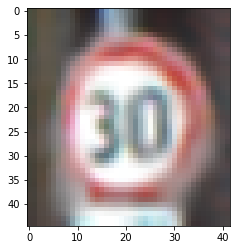

In [286]:
new_img = add_fog(img1, patches = 42*0.8)
plt.imshow(new_img)

plt.imsave('sample1_fog.jpeg', new_img.astype(np.uint8))

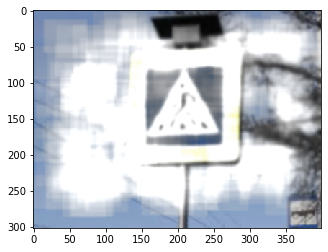

In [287]:
new_img = add_fog(img2, patches = 400*0.7)
plt.imshow(new_img)

plt.imsave('sample3_fog.jpeg', new_img.astype(np.uint8))

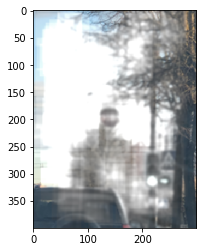

In [288]:
new_img = add_fog(img3, patches = 300*0.8)
plt.imshow(new_img)

plt.imsave('sample4_fog.jpeg', new_img.astype(np.uint8))

### Extreme Darkness

In [170]:
def extreme_dark(img):
    image = img.copy()
    imagePIL = Image.fromarray(np.uint8(image)).convert('RGB')
    
    # reduce brightness
    enhancer = ImageEnhance.Brightness(imagePIL)
    imagePIL = enhancer.enhance(0.3)
    
    # reduce satuation
    enhancer = ImageEnhance.Color(imagePIL)
    imagePIL = enhancer.enhance(0.3)
    
    # add slight blur
    image = np.array(imagePIL)
    image = cv2.blur(image, (2, 2))
    return image

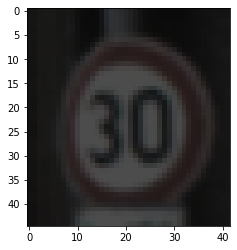

In [290]:
new_img = extreme_dark(img1)
plt.imshow(new_img)

plt.imsave('sample1_dark.jpeg', new_img.astype(np.uint8))

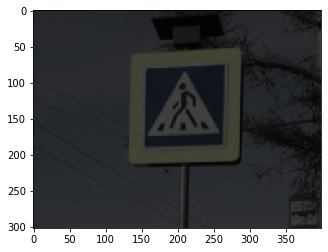

In [291]:
new_img = extreme_dark(img2)
plt.imshow(new_img)

plt.imsave('sample13_dark.jpeg', new_img.astype(np.uint8))

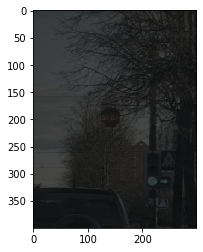

In [292]:
new_img = extreme_dark(img3)
plt.imshow(new_img)

plt.imsave('sample4_dark.jpeg', new_img.astype(np.uint8))

### Extreme Brightness

In [295]:
def get_black_pixels(image):
    imagePIL = Image.fromarray(np.uint8(image)).convert('RGB')
    pixels = imagePIL.getdata()
    nblack = 0
    for pixel in pixels:
        if sum(pixel) == 0:
            nblack += 1
    percent_black = nblack/len(pixels)
    return percent_black

def reduce_black_pixels(img):
    image = img.copy()
    threshold_level = 50
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    coords = np.column_stack(np.where(gray < threshold_level)) # find coords of pixels that are black
    indexLst = random.sample(list(range(len(coords))), int(len(coords)*0.8))
    for index in indexLst:
        loc = coords[index]
        image[loc[0], loc[1],:] += random.randint(100, 180)
    return image

def extreme_bright(img):
    image = img.copy()
    
    # check for black pixel components
    percent = get_black_pixels(image)
    if percent >= 0.25:
        image = reduce_black_pixels(image)
    
    imagePIL = Image.fromarray(np.uint8(image)).convert('RGB')
    
    # reduce satuation
    enhancer = ImageEnhance.Color(imagePIL)
    imagePIL = enhancer.enhance(0.5)
    
    # reduce brightness
    enhancer = ImageEnhance.Brightness(imagePIL)
    imagePIL = enhancer.enhance(2.5)

    
    # add slight blur
    image = np.array(imagePIL)
    image = cv2.blur(image, (3, 3))
    return image

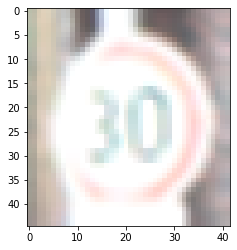

In [296]:
new_img = extreme_bright(img1)
plt.imshow(new_img)

plt.imsave('sample1_bright.jpeg', new_img.astype(np.uint8))

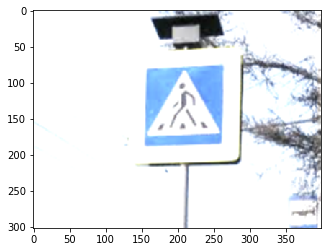

In [297]:
new_img = extreme_bright(img2)
plt.imshow(new_img)

plt.imsave('sample3_bright.jpeg', new_img.astype(np.uint8))

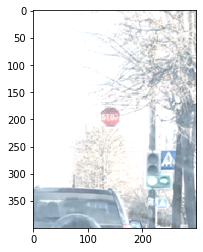

In [298]:
new_img = extreme_bright(img3)
plt.imshow(new_img)

plt.imsave('sample4_bright.jpeg', new_img.astype(np.uint8))